### Given an embedding of SIFT descriptors and their corresponding metadata, perform downstream analysis

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import seaborn as sns
import tiffile as tiff
import random
import anndata as ad
import pandas as pd
from sklearn.metrics import silhouette_score
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

random.seed(0)
np.random.seed(0)

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

In [3]:
# load the anndata file with the SIFT descriptors
adata = ad.read_h5ad('/gladstone/engelhardt/lab/adamw/saft_figuren/analysis/adata_20250225_processed_20250310.h5ad')

# the number of rows when first loading the data represents the number of SIFT descriptors used for clustering
num_rows_cluster = adata.obs.shape[0]

adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 3389740 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10', 'roi_mean_rfp_intensity', 'roi_rfp_pos_frac', 'roi_rfp_morans_I', 'roi_bf_morans_I'
    uns: 'kmeans_10', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9'
    obsm: 'X_pca'

In [4]:
# plot the shape of the PCA embeddings after dropping NaN values
adata.obsm['X_pca'][:, 0]

array([-0.74040007,  8.6010379 ,  3.66278238, ..., -1.32592509,
        5.49960101,  7.28865299])

In [5]:
# move PC1 and PC2 from adata.obsm['X_pca'] to adata.obs['PC1'] and adata.obs['PC2']
adata.obs['PC1'] = adata.obsm['X_pca'][:, 0]
adata.obs['PC2'] = adata.obsm['X_pca'][:, 1]

In [6]:
# compute a replicate_id integer based on the well_id
# if the well_id ends in an odd number, then the replicate_id is 1
# if the well_id ends in an even number, then the replicate_id is 0
adata.obs['replicate_id'] = adata.obs['well_id'].apply(lambda x: int(x[-1]) % 2)

In [7]:
# compute the ROI radius for each SIFT descriptor
adata.obs['roi_radius'] = adata.obs['scales'] * (2 ** (adata.obs['octaves'] + 1))
adata.obs['roi_radius'].value_counts()

roi_radius
2      1828941
4      1058462
6       434129
8        45416
12       14955
384       4601
16        2036
256        789
24         403
32           4
128          3
192          1
Name: count, dtype: int64

In [8]:
# make a copy of the entire adata object before subsetting
adata_full = adata.copy()

# subset the entire adata object to just 50k randomly sampled rows
# this should help with runtime issues and overpowered statistical testing
num_rows = 50000
adata = adata[np.random.choice(adata.shape[0], num_rows, replace=False), :]
adata.obs.reset_index(drop=True, inplace=True)
adata

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 50000 × 128
    obs: 'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'filename', 'scales', 'octaves', 'sigmas', 'orientations', 'x', 'y', 'n_og_keypoints', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9', 'kmeans_10', 'roi_mean_rfp_intensity', 'roi_rfp_pos_frac', 'roi_rfp_morans_I', 'roi_bf_morans_I', 'PC1', 'PC2', 'replicate_id', 'roi_radius'
    uns: 'kmeans_10', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8', 'kmeans_9'
    obsm: 'X_pca'

In [9]:
adata.obs.head()

donor_id  time well_id  rasa2ko_titration  et_ratio   entropy  p_areas  \
0         3    61      F5               50.0    1.4142  4.049472    82657   
1         2    65      D2              100.0    2.0000  3.704826    86717   
2         3    26      J4               50.0    0.7071  4.404640    97741   
3         3    46      H4               50.0    1.0000  4.169801    77859   
4         3    54     F10                6.3    1.4142  4.234559   123534   

                                            filename  scales  octaves  ...  \
0  /gladstone/engelhardt/lab/MarsonLabIncucyteDat...       2        0  ...   
1  /gladstone/engelhardt/lab/MarsonLabIncucyteDat...       1        0  ...   
2  /gladstone/engelhardt/lab/MarsonLabIncucyteDat...       1        0  ...   
3  /gladstone/engelhardt/lab/MarsonLabIncucyteDat...       1        0  ...   
4  /gladstone/engelhardt/lab/MarsonLabIncucyteDat...       2        0  ...   

   kmeans_9  kmeans_10  roi_mean_rfp_intensity  roi_rfp_pos_frac  \
0         3          0                8.564629           0.96875   
1         5          1                7.736015           1.00000   
2         3          0                9.457946           1.00000   
3         5          1               10.890960           1.00000   
4         4          2                0.306651           0.00000   

   roi_rfp_morans_I roi_bf_morans_I       PC1       PC2 replicate_id  \
0          0.632002        0.313112 -4.136739  5.634490            1   
1          0.397256        0.257025 -2.804754 -2.371525            0   
2          0.450419       -0.018469 -0.648392  5.092073            0   
3          0.525630        0.374347 -1.257959 -3.757435            0   
4          0.486479        0.655221  8.420753 -4.997797            0   

  roi_radius  
0          4  
1          2  
2          2  
3          2  
4          4  

[5 rows x 31 columns]

### Compute some SIFT summary statistics that show the number of keypoints per image

In [10]:
entropy_df = adata.obs[['donor_id', 'time', 'well_id', 'replicate_id','rasa2ko_titration', 'et_ratio', 'entropy', 'p_areas', 'n_og_keypoints']].drop_duplicates()
entropy_df

donor_id  time well_id  replicate_id  rasa2ko_titration  et_ratio  \
0             3    61      F5             1               50.0    1.4142   
1             2    65      D2             0              100.0    2.0000   
2             3    26      J4             0               50.0    0.7071   
3             3    46      H4             0               50.0    1.0000   
4             3    54     F10             0                6.3    1.4142   
...         ...   ...     ...           ...                ...       ...   
49916         1    58      F3             1              100.0    1.4142   
49921         4    42      D4             0               50.0    2.0000   
49946         3    22      J7             1               25.0    0.7071   
49965         1     3      F8             0               12.5    1.4142   
49982         3    33      F8             0               12.5    1.4142   

        entropy  p_areas  n_og_keypoints  
0      4.049472    82657            1656  
1      3.704826    86717            1537  
2      4.404640    97741            2648  
3      4.169801    77859            1777  
4      4.234559   123534            2487  
...         ...      ...             ...  
49916  3.657628    60694            1514  
49921  3.993558    50752            1270  
49946  4.372336    91023            2112  
49965  4.438163    36423            1610  
49982  4.125249    47421            1055  

[12605 rows x 9 columns]

In [11]:
entropy_df['n_og_keypoints'].describe()

count    12605.000000
mean      2589.857200
std       1527.870184
min        879.000000
25%       1515.000000
50%       1995.000000
75%       3251.000000
max      16227.000000
Name: n_og_keypoints, dtype: float64

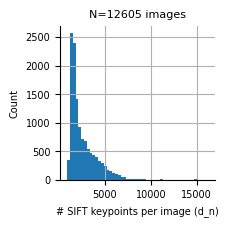

In [12]:
# plot a histogram of the number of keypoints per image
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
entropy_df['n_og_keypoints'].hist(bins=50, ax=ax)
ax.set_xlabel('# SIFT keypoints per image (d_n)')
ax.set_ylabel('Count')
ax.set_title('N={} images'.format(len(entropy_df)))
sns.despine(ax=ax)
# fig.savefig('figures/fig2/n_keypoints_hist.pdf', bbox_inches='tight', dpi=300)
plt.show()

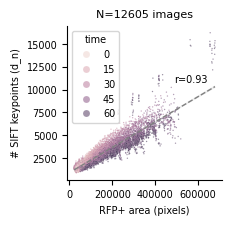

In [16]:
# make a scatterplot of the number of keypoints vs RFP area with the hue being time
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
sns.scatterplot(ax=ax, data=entropy_df, x='p_areas', y='n_og_keypoints', hue='time', s=1, alpha=0.5, rasterized=True)
# annotate with seaborn line of best fit
sns.regplot(ax=ax, data=entropy_df, x='p_areas', y='n_og_keypoints', line_kws={'color': 'grey', 'lw': 1, 'ls': '--'}, scatter=False)
# compute the pearson correlation coefficient
result = stats.pearsonr(entropy_df['p_areas'], entropy_df['n_og_keypoints'])
# annotate with the R2 value
ax.text(x=0.8, y=0.65, s=f"r={result.statistic:.2f}", transform=ax.transAxes, ha='center', va='center')
ax.set_xlabel('RFP+ area (pixels)')
ax.set_ylabel('# SIFT keypoints (d_n)')
ax.set_title('N={} images'.format(len(entropy_df)))

# increase the point size shown in the legend
ax.legend(markerscale=5, title='time')

sns.despine(ax=ax)
# fig.savefig('figures/fig2/n_keypoints_vs_RFP+_scatter.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
result.statistic, result.pvalue

(0.9310877936367169, 0.0)

In [18]:
np.finfo(np.float64).tiny

2.2250738585072014e-308

### Investigate clustering results

Compute silhouette scores for just a subset of the overall dataset since silhouette is O(n^2) in time complexity. Note that the k-means clustering was performed on the entire adata object prior to downsampling to `num_rows` points.

In [19]:
# k-means clustering of SIFT descriptors
k_values = np.arange(3, 11)

# # compute the silhouette score for each value of k on adata
# silhouettes = []
# for k in k_values:
#     colname = 'kmeans_{}'.format(k)
#     # make sure that the clustering results are in category format
#     adata.obs[colname] = adata.obs[colname].astype('category')
#     score = silhouette_score(adata.X, adata.obs[colname])
#     silhouettes.append(score)

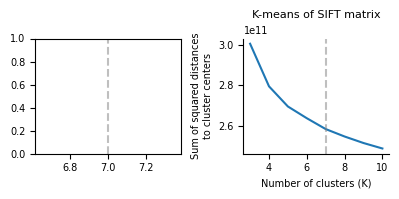

In [20]:


fig, ax = plt.subplots(1, 2, figsize=(4, 2), tight_layout=True)
ax = ax.flatten()

# # plot the silhouette score for each value of k on adata_B4_donor1
# ax[0].plot(k_values, silhouettes)
# ax[0].set_xlabel('Number of clusters (K)')
# ax[0].set_ylabel('Silhouette score')
# ax[0].set_title('K-means of SIFT matrix')
# sns.despine(ax=ax[0])

# plot the wccs score from adata.uns['kmeans_{k}] for each value of k on the entire dataset
wccs = [ adata.uns['kmeans_{}'.format(k)]['wccs'] for k in k_values ]
ax[1].plot(k_values, wccs)
ax[1].set_xlabel('Number of clusters (K)')
ax[1].set_ylabel('Sum of squared distances\nto cluster centers')
ax[1].set_title('K-means of SIFT matrix')
sns.despine(ax=ax[1])

# draw vertical dashed grey line at k=7 for both subplots
for i in range(2):
    ax[i].axvline(7, color='grey', linestyle='--', alpha=0.5)

# fig.savefig('figures/fig2/kmeans_silhouette_wccs.pdf', bbox_inches='tight')

plt.show()

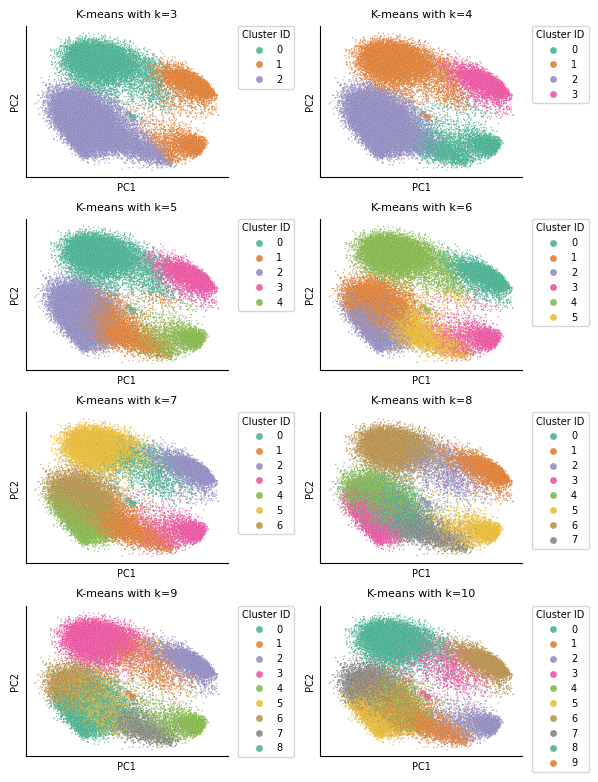

In [21]:
# show the PCA embeddings colored by K-means cluster
fig, ax = plt.subplots(4, 2, figsize=(6, 8), tight_layout=True)
ax = ax.flatten()

for i, k in enumerate(k_values[:8]):
    sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='kmeans_{}'.format(k), palette='Dark2', alpha=0.7, s=1, ax=ax[i], rasterized=True)
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    sns.despine(ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('K-means with k={}'.format(k))
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Cluster ID', markerscale=5)

# fig.savefig('figures/fig2/kmeans_pca_embeddings.pdf', bbox_inches='tight', dpi=300)

plt.show()

Despite the silhouette score being highest for `k=4` clusters, we chose to move forward with `k=7` clusters for downstream analysis as this gave us additional granularity for explaining variation in SIFT descriptors.

### Show the clustering results alongside ROIs for representative descriptors

This will help us qualitatively describe the meaning of each cluster

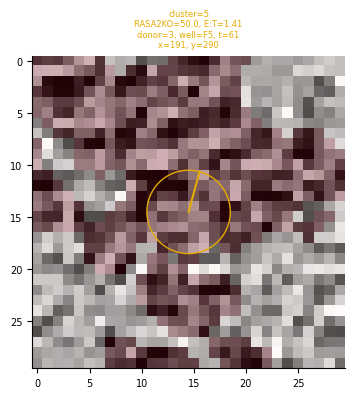

In [22]:
def plot_sift_roi(row, ax, offset=None, cluster_col='kmeans_7', add_rfp_mask=False):
    '''
    Plot the SIFT descriptors for a single ROI. Input is a single row of the adata.obs dataframe that contains the columns: filename, x, y,
    '''
    image = tiff.imread(row['filename'])
    # normalize the intensity of the image to range [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # compute the radius for this SIFT descriptor
    radius = row['roi_radius']

    # only show the true ROI if offset is None, otherwise show the ROI with the specified offset
    if offset is None:
        offset = radius
    
    # crop the image to the ROI
    xmin, xmax = row['x'] - offset, row['x'] + offset
    ymin, ymax = row['y'] - offset, row['y'] + offset
    if xmin < 0:
        xmin = 0
    if ymin < 0:
        ymin = 0
    if xmax > image.shape[0]:
        xmax = image.shape[0]
    if ymax > image.shape[1]:
        ymax = image.shape[1]
    image = image[xmin:xmax, ymin:ymax]

    # optional argument to load the red channel where RFP is expressed in cancer cells
    if add_rfp_mask:
        rfp_filename = row['filename'].replace('phase_registered', 'red_registered')
        rfp_image = tiff.imread(rfp_filename)

        # # normalize the entire image intensity values to range [0, 1]
        # rfp_image = (rfp_image - rfp_image.min()) / (rfp_image.max() - rfp_image.min())

        rfp_image = rfp_image[xmin:xmax, ymin:ymax]
        # threshold the RFP channel into a binary mask
        rfp_mask = rfp_image > 3.5
        ax.imshow(rfp_mask, cmap='Reds', alpha=1.0, vmin=0, vmax=1)
        phase_alpha = 0.7
    else:
        phase_alpha = 1.0
    
    # plot the greyscale image
    ax.imshow(image, cmap='gray', alpha=phase_alpha, vmin=0, vmax=1)

    # find the center point of the image.shape matrix
    height, width = image.shape
    x = (width - 1) / 2.0
    y = (height - 1) / 2.0
    
    # set color of title and circle based on the cluster_col value and the Dark2 colormap
    color = cm.Dark2(row[cluster_col])
    # annotate the ROI with a circle that has r=radius
    circle = patches.Circle((x, y), radius, edgecolor=color, facecolor='none')
    ax.add_patch(circle)

    # add a line going from the center of the circle to the perimeter of the circle and an angle of row['orientations']
    angle = row['orientations']
    ax.plot([x, x + radius * np.cos(angle)], [y, y + radius * np.sin(angle)], color=color)


    sns.despine(ax=ax)
    ax.set_title('cluster={}\nRASA2KO={}, E:T={}\ndonor={}, well={}, t={}\nx={}, y={}'.format(row[cluster_col], round(row['rasa2ko_titration'], 2), round(row['et_ratio'], 2), row['donor_id'], row['well_id'], row['time'], row['x'], row['y']), fontsize=6)
    # set color of the title based on the cluster_col value and the Dark2 colormap
    ax.title.set_color(color)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
plot_sift_roi(adata.obs.iloc[0], ax, offset=15, add_rfp_mask=True)

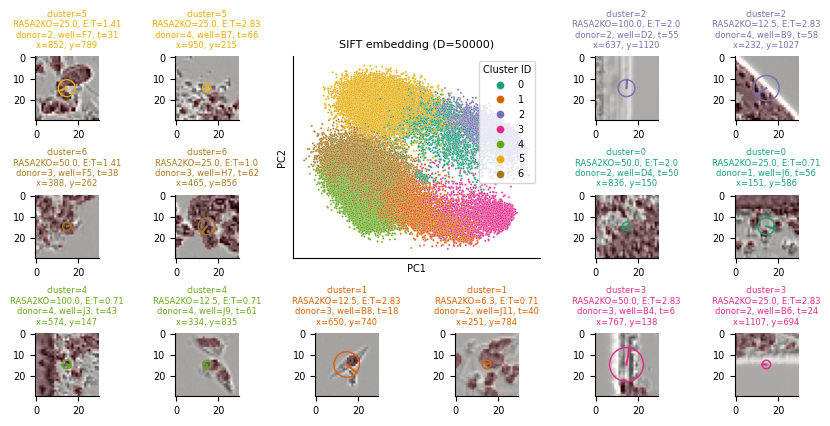

In [23]:
def plot_two_random_rois(adata, cluster_id, ax1, ax2, cluster_col='kmeans_7', offset=15, add_rfp_mask=False):
    ''' Plot two random ROIs belonging to the cluster_col==cluster_id '''
    temp_df = adata.obs[adata.obs[cluster_col]==cluster_id]
    # temp_df = temp_df.iloc[np.random.choice(temp_df.shape[0], 2, replace=False), :]
    plot_sift_roi(temp_df.iloc[2], ax1, offset=offset, add_rfp_mask=add_rfp_mask)
    plot_sift_roi(temp_df.iloc[3], ax2, offset=offset, add_rfp_mask=add_rfp_mask)

# create a 7x3 grid of subplots where the middle 3 rows and columns are merged into one 3x3 subplot 
fig, ax = plt.subplots(3, 6, figsize=(8.5, 4.25), tight_layout=True)
# merge the middle 3 rows and columns into one 3x3 subplot
gs = ax[0, 2].get_gridspec()
for i in range(0, 2):
    for j in range(2, 4):
        ax[i, j].remove()

# plot the PCA embedding for donor_id==1 and well_id==B4 in the big center subplot
axbig = fig.add_subplot(gs[0:2, 2:4])
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='kmeans_7', palette='Dark2', alpha=1, s=2, ax=axbig, rasterized=True)
axbig.set_title('SIFT embedding (D={})'.format(num_rows))
# axbig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='K-means k=7')
axbig.legend(title='Cluster ID', markerscale=4)
sns.despine(ax=axbig)
axbig.set_xticks([])
axbig.set_yticks([])

# plot ROIs on the left and right of the big center subplot
plot_two_random_rois(adata, 5, ax[0, 0], ax[0, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 6, ax[1, 0], ax[1, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 4, ax[2, 0], ax[2, 1], add_rfp_mask=True)
plot_two_random_rois(adata, 2, ax[0, 4], ax[0, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 0, ax[1, 4], ax[1, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 3, ax[2, 4], ax[2, 5], add_rfp_mask=True)
plot_two_random_rois(adata, 1, ax[2, 2], ax[2, 3], add_rfp_mask=True)

# fig.savefig('figures/fig2/multipanel_embedding_rois_rfp.pdf', bbox_inches='tight', dpi=300)

plt.show()

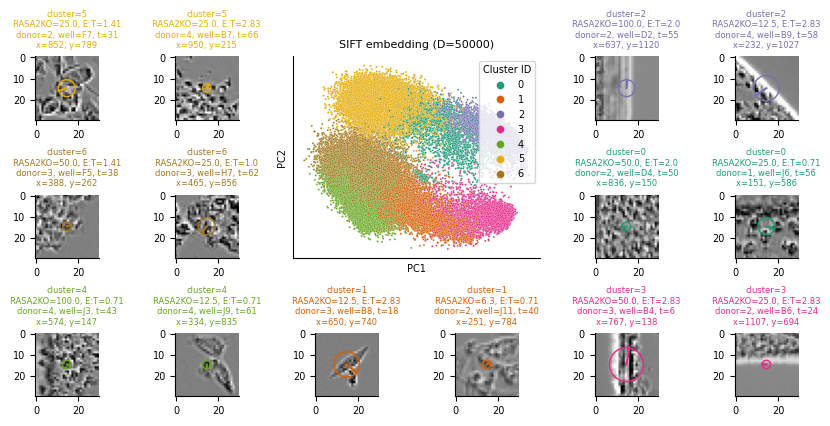

In [24]:
# create a 7x3 grid of subplots where the middle 3 rows and columns are merged into one 3x3 subplot 
fig, ax = plt.subplots(3, 6, figsize=(8.5, 4.25), tight_layout=True)
# merge the middle 3 rows and columns into one 3x3 subplot
gs = ax[0, 2].get_gridspec()
for i in range(0, 2):
    for j in range(2, 4):
        ax[i, j].remove()

# plot the PCA embedding for donor_id==1 and well_id==B4 in the big center subplot
axbig = fig.add_subplot(gs[0:2, 2:4])
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='kmeans_7', palette='Dark2', alpha=1, s=2, ax=axbig, rasterized=True)
axbig.set_title('SIFT embedding (D={})'.format(num_rows))
# axbig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='K-means k=7')
axbig.legend(title='Cluster ID', markerscale=4)
sns.despine(ax=axbig)
axbig.set_xticks([])
axbig.set_yticks([])

# plot ROIs on the left and right of the big center subplot
plot_two_random_rois(adata, 5, ax[0, 0], ax[0, 1], add_rfp_mask=False)
plot_two_random_rois(adata, 6, ax[1, 0], ax[1, 1], add_rfp_mask=False)
plot_two_random_rois(adata, 4, ax[2, 0], ax[2, 1], add_rfp_mask=False)
plot_two_random_rois(adata, 2, ax[0, 4], ax[0, 5], add_rfp_mask=False)
plot_two_random_rois(adata, 0, ax[1, 4], ax[1, 5], add_rfp_mask=False)
plot_two_random_rois(adata, 3, ax[2, 4], ax[2, 5], add_rfp_mask=False)
plot_two_random_rois(adata, 1, ax[2, 2], ax[2, 3], add_rfp_mask=False)

# fig.savefig('figures/fig2/multipanel_embedding_rois_phase.pdf', bbox_inches='tight', dpi=300)


plt.show()

### Plot large ROIs and annotate them with multiple SIFT keypoints colored by K-means cluster ID

/tmp/ipykernel_2033578/1055352750.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(label) + roi_center[0]) for label in xtick_labels])
/tmp/ipykernel_2033578/1055352750.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(label) + roi_center[1]) for label in ytick_labels])
/tmp/ipykernel_2033578/1055352750.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(int(label) + roi_center[0]) for label in xtick_labels])
/tmp/ipykernel_2033578/1055352750.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(int(label) + roi_center[1]) for label in ytick_label

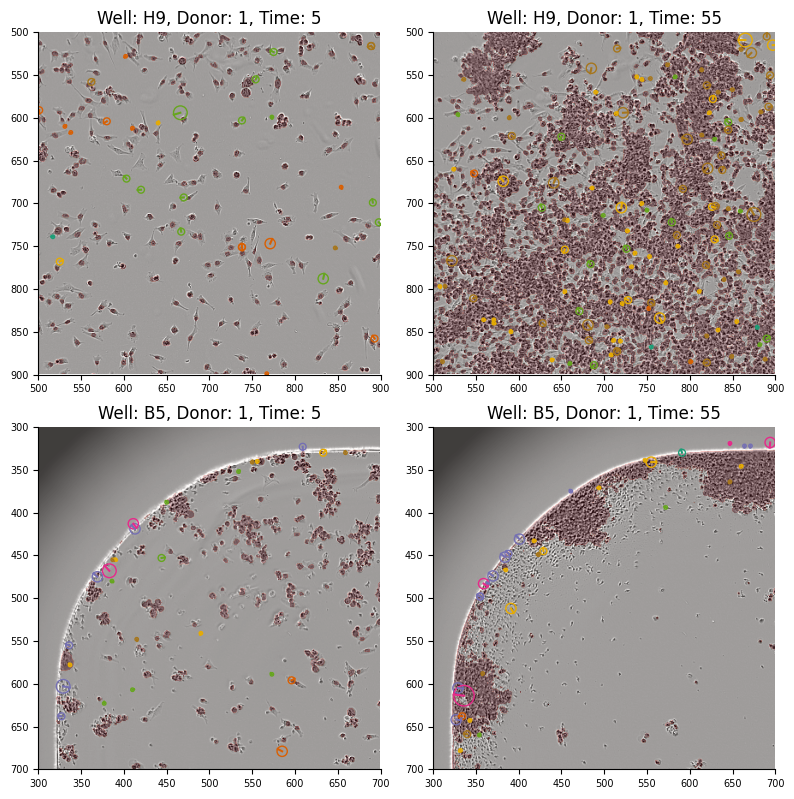

In [25]:
def plot_large_roi_w_keypoints(df, ax, well_id, donor_id, time_point, roi_center, roi_radius):
    '''
    Given a specific image, ROI within that image, and full set of SIFT descriptors for that ROI, plot the SIFT keypoints on top of the bright field + RFP image

    Parameters
    ----------
     df : pd.DataFrame
        dataframe of SIFT keypoints and descriptors. Columns should include ['well_id', 'donor_id', 'time', 'filename', 'x', 'y', 'scales', 'octaves', 'orientations', 'kmeans_7']
    ax : matplotlib axes object
        axes object to plot on
    well_id : str
        well id of the image we wish to plot
    donor_id : str
        donor id of the image we wish to plot
    time_point : int
        time point of the image we wish to plot
    roi_center : tuple of int
        center of the ROI in x-y coordinates
    roi_radius : int
        radius of the ROI in pixels
    '''
    # subset the dataframe to the specified well_id, donor_id, and time
    df = df[(df['well_id']==well_id) & (df['donor_id']==donor_id) & (df['time']==time_point)]

    # create a list of all the image file paths that correspond to this donor_id
    phase_filename = df['filename'].iloc[0]
    red_filename = phase_filename.replace('phase', 'red')

    # subset the list to the specified time point and load the images
    resized_latish_phase = tiff.imread(phase_filename)
    resized_latish_red = tiff.imread(red_filename)
    # threshold the red channel into a binary mask
    red_frame = resized_latish_red > 3.5

    # normalize intensity of the phase image
    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

    # find the x_min, x_max, y_min, y_max boundaries of the image based on the roi_center and roi_radius
    x_min = roi_center[0] - roi_radius
    x_max = roi_center[0] + roi_radius
    y_min = roi_center[1] - roi_radius
    y_max = roi_center[1] + roi_radius

    ax.imshow(red_frame[x_min:x_max, y_min:y_max], cmap='Reds', alpha = 1.0)
    ax.imshow(phase_frame[x_min:x_max, y_min:y_max], cmap='gray', alpha = .75)

    # find all the SIFT keypoints in this image (each row in df) and annotate their location
    for idx, row in df.iterrows():
        # check to see if the x-y position of this SIFT keypoint falls within xx_min:x_max, y_min:y_max
        key_x = row['x']
        key_y = row['y']
        if (key_x < x_max) and (key_x > x_min) and (key_y < y_max) and (key_y > y_min):
            key_radius = row['roi_radius']
            # set color of title and circle based on the cluster_col value and the Dark2 colormap
            color = cm.Dark2(row['kmeans_7'])
            # annotate the ROI with a circle that has r=radius
            circle = patches.Circle((key_x-x_min, key_y-y_min), key_radius, edgecolor=color, facecolor='none')
            ax.add_patch(circle)
        
            # add a line going from the center of the circle to the perimeter of the circle and an angle of row['orientations']
            angle = row['orientations']
            ax.plot([key_x-x_min, key_x-x_min + key_radius * np.cos(angle)], [key_y-y_min, key_y-y_min + key_radius * np.sin(angle)], color=color)

    ax.set_title('Well: {}, Donor: {}, Time: {}'.format(well_id,donor_id,time_point), size = 12)
    # remove the axes ticks and labels
    sns.despine(ax=ax)
    ax.set_xlim([0, roi_radius*2])
    ax.set_ylim([roi_radius*2, 0])

    # offset the x and y tick labels by the ROI center values
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
    ax.set_xticklabels([str(int(label) + roi_center[0]) for label in xtick_labels])
    ax.set_yticklabels([str(int(label) + roi_center[1]) for label in ytick_labels])
    
    return ax

fig, ax = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
ax = ax.flatten()
plot_large_roi_w_keypoints(adata_full.obs, ax[0], well_id='H9', donor_id=1, time_point=5, roi_center=(500,500), roi_radius=200)
plot_large_roi_w_keypoints(adata_full.obs, ax[1], well_id='H9', donor_id=1, time_point=55, roi_center=(500,500), roi_radius=200)
plot_large_roi_w_keypoints(adata_full.obs, ax[2], well_id='B5', donor_id=1, time_point=5, roi_center=(300,300), roi_radius=200)
plot_large_roi_w_keypoints(adata_full.obs, ax[3], well_id='B5', donor_id=1, time_point=55, roi_center=(300,300), roi_radius=200)

plt.show()

### Plot the entire well for representative image frames

Save examples both with and without the RFP channel superimposed

In [26]:
def plot_entire_well(df, ax, well_id, donor_id, time_point, trim=100, rfp=False):
    '''
    Plot the entire brightfield (and optionally RFP) image for a single well.

    Parameters
    ----------
     df : pd.DataFrame
        dataframe of SIFT keypoints and descriptors. Columns should include ['well_id', 'donor_id', 'time', 'filename', 'x', 'y', 'scales', 'octaves', 'orientations', 'kmeans_7']
    ax : matplotlib axes object
        axes object to plot on
    well_id : str
        well id of the image we wish to plot
    donor_id : str
        donor id of the image we wish to plot
    time_point : int
        time point of the image we wish to plot
    trim : int
        number of pixels to trim from the edges of the image
    rfp : bool
        whether or not to plot the red channel
    '''
    # subset the dataframe to the specified well_id, donor_id, and time
    df = df[(df['well_id']==well_id) & (df['donor_id']==donor_id) & (df['time']==time_point)]

    # create a list of all the image file paths that correspond to this donor_id
    phase_filename = df['filename'].iloc[0]
    red_filename = phase_filename.replace('phase', 'red')

    # subset the list to the specified time point and load the images
    resized_latish_phase = tiff.imread(phase_filename)
    resized_latish_red = tiff.imread(red_filename)
    # threshold the red channel into a binary mask
    red_frame = resized_latish_red > 3.5

    # normalize intensity of the phase image
    phase_frame = cv.normalize(resized_latish_phase, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

    # plot the phase image with the red mask superimposed
    trim=100
    if rfp:
        ax.imshow(red_frame[trim:-trim,trim:-trim], cmap='Reds', alpha = 1.0)
    ax.imshow(phase_frame[trim:-trim,trim:-trim], cmap='gray', alpha = .75)
    ax.set_title('Well: {}, Donor: {}, Time: {}'.format(well_id,donor_id,time_point), size = 12)
    # remove the axes ticks and labels
    ax.axis('off')



In [27]:
import os
os.getcwd()

'/gladstone/engelhardt/lab/adamw/saft_figuren'

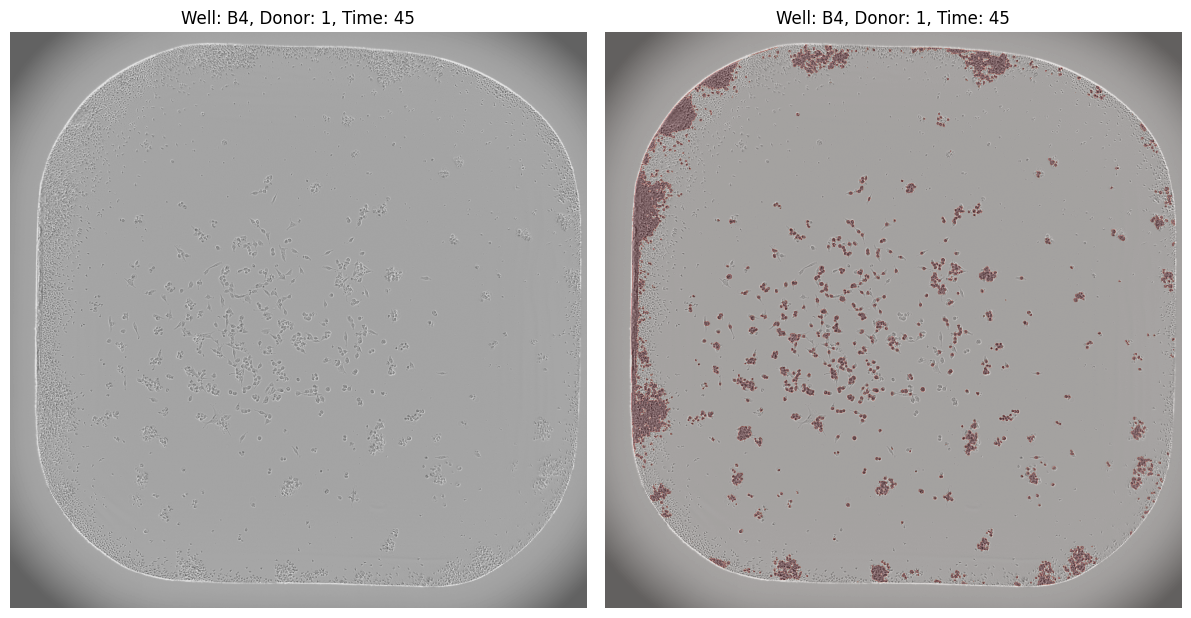

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
ax = ax.flatten()
plot_entire_well(adata_full.obs, ax[0], well_id='B4', donor_id=1, time_point=45, trim=100, rfp=False)
plot_entire_well(adata_full.obs, ax[1], well_id='B4', donor_id=1, time_point=45, trim=100, rfp=True)
# fig.savefig('figures/B4_donor1_time45.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Analyze ROIs surrounding each SIFT keypoint to quantitatively describes K-means clusters obtained from the SIFT descriptor matrix

This can include looking at position of keypoints in the well, RFP intensity, spatial heterogeneity of phase and red images surrounding each ROI.

Group clusters into their ontological categories when plotting violins and boxplots

In [31]:
# add a new column to adata.obs that is the cluster_nickname
cluster_nickname_dict = {
    0: 'mixed',
    1: 'singlets_1',
    2: 'edges_1',
    3: 'edges_2',
    4: 'singlets_2',
    5: 'aggregates_1',
    6: 'aggregates_2'
}
cluster_group_dict = {
    0: 'mixed',
    1: 'singlets',
    2: 'edges',
    3: 'edges',
    4: 'singlets',
    5: 'aggregates',
    6: 'aggregates'
}
adata.obs['cluster_nickname'] = adata.obs['kmeans_7'].map(cluster_nickname_dict)
adata.obs['cluster_group'] = adata.obs['kmeans_7'].map(cluster_group_dict)

# create a column for the dark2 color palette mapping of each cluster
cmap = plt.cm.get_cmap('Dark2')
colors = cmap(np.arange(7))
cluster_color_dict = {
    0: colors[0],
    1: colors[1],
    2: colors[2],
    3: colors[3],
    4: colors[4],
    5: colors[5],
    6: colors[6]
}

/tmp/ipykernel_2033578/2692167061.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2')


### Start by looking at the distance of each SIFT keypiont from the center of the well

Keypoints belonging to edge clusters will have a larger distance from the center and a smaller standard deviation in distance compared to non-edge clusters.

In [32]:
# use the xy-coordinates of each SIFT descriptor to find its radius (in pixels) away from the center of the image
# start by shifting x and y coordinates to be centered at 0,0
adata.obs['x_centered'] = adata.obs['x'] - adata.obs['x'].mean()
adata.obs['y_centered'] = adata.obs['y'] - adata.obs['y'].mean()
# compute the radius of each SIFT descriptor
adata.obs['distance_from_center'] = np.sqrt(adata.obs['x_centered']**2 + adata.obs['y_centered']**2)
adata.obs['distance_from_center'].describe()

# compute square root of the distance_from_center values
adata.obs['sqrt_distance_from_center'] = np.sqrt(adata.obs['distance_from_center']) / adata.obs['distance_from_center'].max()

In [36]:
# compute the standard deviation in the distance_from_center values within each kmeans_7 cluster
cluster_positions_df = []
for k, group in adata.obs.groupby('kmeans_7'):
    mean = group['distance_from_center'].mean()
    stdev = group['distance_from_center'].std()
    cluster_group = group['cluster_group'].iloc[0]
    cluster_positions_df.append(pd.DataFrame({'kmeans_7': [k], 
                                          'cluster_group': [cluster_group],
                                          'distance_from_center_mean': [mean],
                                          'distance_from_center_stdev': [stdev]}))
cluster_positions_df = pd.concat(cluster_positions_df, ignore_index=True)
cluster_positions_df

/tmp/ipykernel_2033578/752164267.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for k, group in adata.obs.groupby('kmeans_7'):


kmeans_7 cluster_group  distance_from_center_mean  \
0         0         mixed                 443.331213   
1         1      singlets                 384.738122   
2         2         edges                 530.797486   
3         3         edges                 524.271944   
4         4      singlets                 316.647067   
5         5    aggregates                 364.061252   
6         6    aggregates                 321.356964   

   distance_from_center_stdev  
0                  105.799357  
1                  140.509623  
2                   37.050528  
3                   36.889634  
4                  136.425576  
5                  137.346090  
6                  141.601395

In [35]:
# compute the standard deviation in the distance_from_center values within each cluster group
cluster_group_positions_df = []
for g, group in adata.obs.groupby('cluster_group'):
    mean = group['distance_from_center'].mean()
    stdev = group['distance_from_center'].std()
    cluster_group = group['cluster_group'].iloc[0]
    cluster_group_positions_df.append(pd.DataFrame({ 
                                          'cluster_group': [g],
                                          'distance_from_center_mean': [mean],
                                          'distance_from_center_stdev': [stdev]}))
cluster_group_positions_df = pd.concat(cluster_group_positions_df, ignore_index=True)
cluster_group_positions_df

cluster_group  distance_from_center_mean  distance_from_center_stdev
0    aggregates                 340.675739                  141.297433
1         edges                 528.483594                   37.123137
2         mixed                 443.331213                  105.799357
3      singlets                 342.248421                  141.858006

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


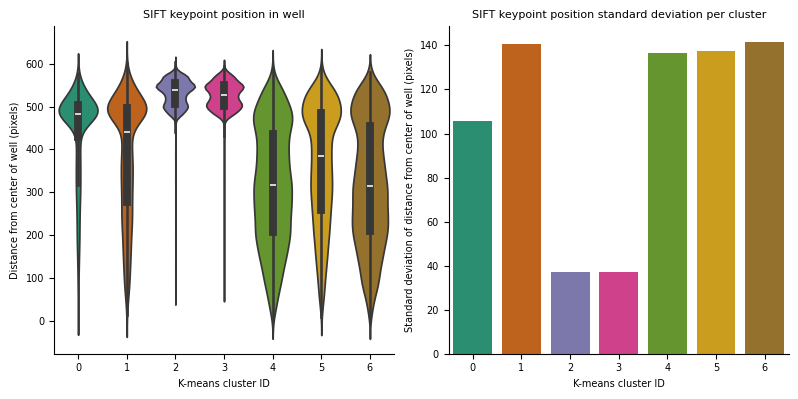

In [ ]:
# plot the SIFT descriptor radii from image centers for each kmeans_7 cluster
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

# violin plot of the radius from center of each SIFT descriptor
sns.violinplot(ax=ax[0], data=adata.obs, x='kmeans_7', y='distance_from_center', hue='kmeans_7', legend=False, palette='Dark2')
ax[0].set_title('SIFT keypoint position in well')
ax[0].set_xlabel('K-means cluster ID')
ax[0].set_ylabel('Distance from center of well (pixels)')
sns.despine(ax=ax[0])

# bar plot of the variance of the radius from center
sns.barplot(ax=ax[1], data=cluster_positions_df, x='kmeans_7', y='distance_from_center_stdev', hue='kmeans_7', legend=False, palette='Dark2')
ax[1].set_title('SIFT keypoint position standard deviation per cluster')
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('Standard deviation of distance from center of well (pixels)')
sns.despine(ax=ax[1])
plt.show()

In [39]:
edge_df = adata.obs[adata.obs['cluster_group'] == 'edges']
non_edge_df = adata.obs[adata.obs['cluster_group'] != 'edges']

edge_df['distance_from_center'].describe()

count    9597.000000
mean      528.483594
std        37.123137
min        51.049501
25%       504.347502
50%       534.437732
75%       552.333830
max       603.198352
Name: distance_from_center, dtype: float64

In [40]:
non_edge_df['distance_from_center'].describe()

count    40403.000000
mean       346.586372
std        141.697101
min          0.801188
25%        233.030403
50%        356.805256
75%        478.710211
max        601.886913
Name: distance_from_center, dtype: float64

In [42]:
# divide the standard deviation of the non_edge_df['distance_from_center'] by the standard deviation of the edge_df['distance_from_center']
edge_stdev = edge_df['distance_from_center'].std()
non_edge_stdev = non_edge_df['distance_from_center'].std()
non_edge_stdev / edge_stdev

3.8169484867165986

In [43]:
# compute a t-test comparing the standard deviation of the non_edge_df['distance_from_center'] to the standard deviation of the edge_df['distance_from_center']
stats.ttest_ind(non_edge_df['distance_from_center'], edge_df['distance_from_center'], equal_var=False)

TtestResult(statistic=-227.27481584521416, pvalue=0.0, df=49664.813957359984)

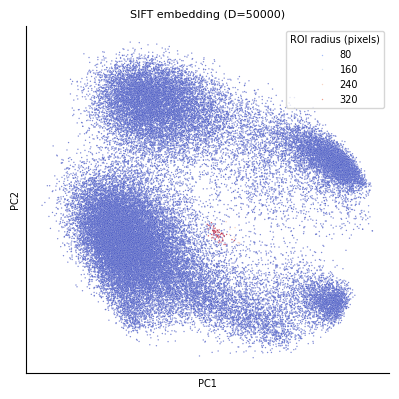

In [ ]:
# plot the PCA embedding annotated by roi_radius
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='roi_radius', palette='coolwarm', ax=ax, s=1, alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('SIFT embedding (D={})'.format(num_rows))
ax.legend(title='ROI radius (pixels)')
sns.despine(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

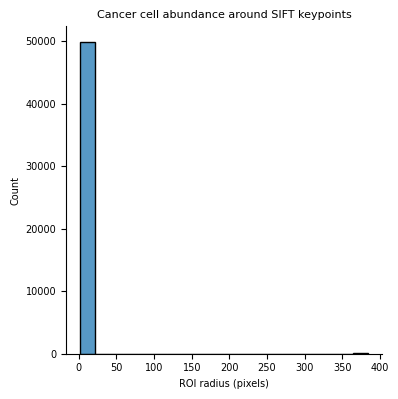

In [44]:
# plot a histogram of roi_radius
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.histplot(data=adata.obs, x='roi_radius', bins=20, ax=ax)
ax.set_xlabel('ROI radius (pixels)')
ax.set_ylabel('Count')
ax.set_title('Cancer cell abundance around SIFT keypoints'.format(num_rows))
sns.despine(ax=ax)
plt.show()

In [45]:
# say that all plate-wide striations have an ROI radius of >250 pixels
adata.obs['plate_wide_striation'] = adata.obs['roi_radius'] > 250

In [47]:
# find the proportion of rows in cluster 0 that are plate-wide striations
num_cluster_0_rows = adata.obs[adata.obs['kmeans_7'] == 0].shape[0]
plate_wide_striation_frac = adata.obs[adata.obs['kmeans_7'] == 0]['plate_wide_striation'].mean()
plate_wide_striation_frac, num_cluster_0_rows, num_cluster_0_rows * plate_wide_striation_frac

(0.034139402560455195, 2109, 72.0)

### Look at RFP intensity values near each SIFT descriptor

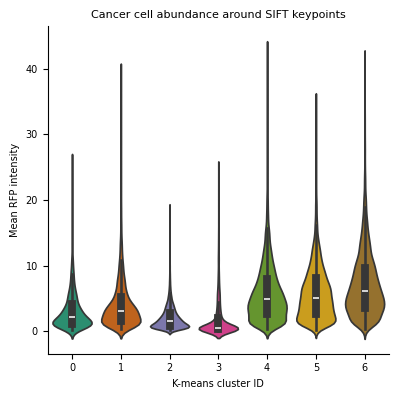

In [48]:
# create a violinplot of roi_mean_rfp_intensity by kmeans_7
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.violinplot(data=adata.obs, x='kmeans_7', y='roi_mean_rfp_intensity', hue='kmeans_7', palette='Dark2', legend=False, ax=ax)
ax.set_xlabel('K-means cluster ID')
ax.set_ylabel('Mean RFP intensity')
ax.set_title('Cancer cell abundance around SIFT keypoints'.format(num_rows))
sns.despine(ax=ax)
plt.show()

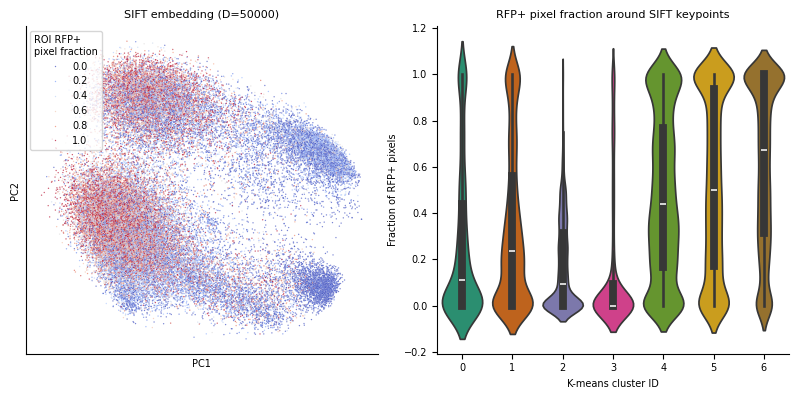

In [49]:
# plot the PCA embedding and violin plot of the ROI fraction of RFP+ pixels (roi_rfp_pos_frac)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='roi_rfp_pos_frac', palette='coolwarm', ax=ax[0], s=1, alpha=0.7)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('SIFT embedding (D={})'.format(num_rows))
ax[0].legend(title='ROI RFP+\npixel fraction')
sns.despine(ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])

sns.violinplot(data=adata.obs, x='kmeans_7', y='roi_rfp_pos_frac', hue='kmeans_7', palette='Dark2', legend=False, ax=ax[1])
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('Fraction of RFP+ pixels')
ax[1].set_title('RFP+ pixel fraction around SIFT keypoints'.format(num_rows))
sns.despine(ax=ax[1])
plt.show()

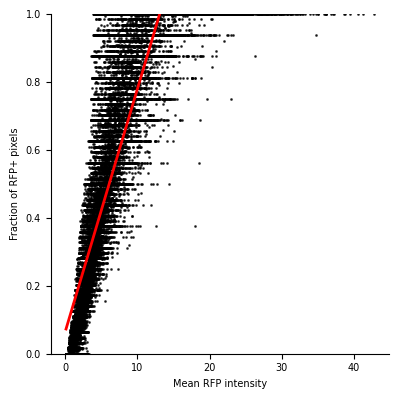

In [50]:
# scatterplot of RFP+ pixel fraction vs roi_mean_rfp_intensity
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
sns.regplot(data=adata.obs, x='roi_mean_rfp_intensity', y='roi_rfp_pos_frac', ax=ax, scatter_kws={'s': 1, 'alpha': 0.7, 'color': 'k'}, line_kws={'color': 'r', 'lw': 2})
ax.set_xlabel('Mean RFP intensity')
ax.set_ylabel('Fraction of RFP+ pixels')
ax.set_ylim([0, 1])
sns.despine(ax=ax)
plt.show()

### Look at the Moran's I statistics between clusters to assess the spatial autocorrelation of both the red and phase channels

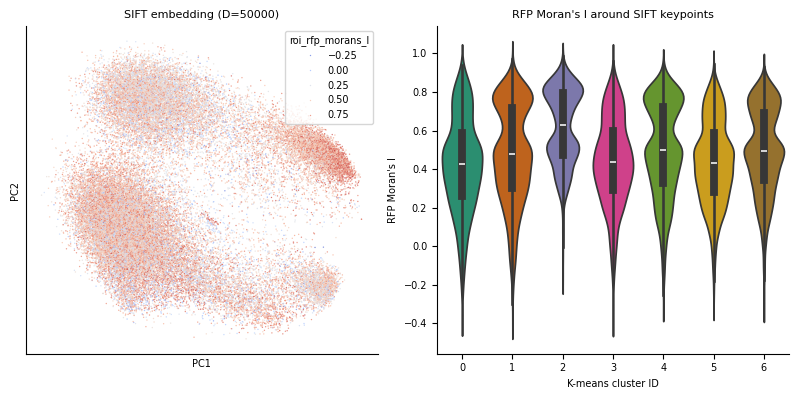

In [51]:
# plot the PCA embedding and violin plot of the RFP Moran's I (roi_rfp_morans_I)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='roi_rfp_morans_I', palette='coolwarm', ax=ax[0], s=1, alpha=0.7)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('SIFT embedding (D={})'.format(num_rows))
sns.despine(ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])

sns.violinplot(data=adata.obs, x='kmeans_7', y='roi_rfp_morans_I', hue='kmeans_7', palette='Dark2', legend=False, ax=ax[1])
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('RFP Moran\'s I')
ax[1].set_title('RFP Moran\'s I around SIFT keypoints')
sns.despine(ax=ax[1])
plt.show()

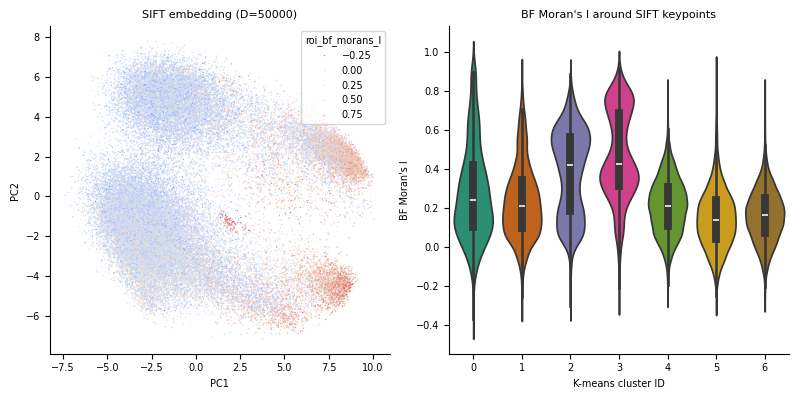

In [52]:
# plot the PCA embedding and violin plot of the ROI brightfield Moran's I (roi_bf_morans_I)
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue='roi_bf_morans_I', palette='coolwarm', ax=ax[0], s=1, alpha=0.7)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('SIFT embedding (D={})'.format(num_rows))
sns.despine(ax=ax[0])

sns.violinplot(data=adata.obs, x='kmeans_7', y='roi_bf_morans_I', hue='kmeans_7', palette='Dark2', legend=False, ax=ax[1])
ax[1].set_xlabel('K-means cluster ID')
ax[1].set_ylabel('BF Moran\'s I')
ax[1].set_title('BF Moran\'s I around SIFT keypoints')
sns.despine(ax=ax[1])
plt.show()

Try to tease out if there are any cluster-specific Moran's I deviations within low, med, or high RFP+ ROIs.

In [53]:
# group the roi_rfp_pos_frac into groups based on having a values in the range of 0 to 0.25, 0.25 to 0.5, 0.5 to 0.75, and 0.75 to 1
adata.obs['roi_rfp_pos_frac_quartile'] = pd.cut(adata.obs['roi_rfp_pos_frac'], bins=[-0.01, 0.25, 0.5, 0.75, 1.01], labels=[0, 1, 2, 3])

In [55]:
# subset adata.obs to just the rows from clusters 1 and 4
df_polar = adata.obs[(adata.obs['kmeans_7'] == 1) | (adata.obs['kmeans_7'] == 4)].copy()

# do the same for aggregate clusters 5 and 6
df_aggregate = adata.obs[(adata.obs['kmeans_7'] == 5) | (adata.obs['kmeans_7'] == 6)].copy()

/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/gladstone/engelhardt/ho

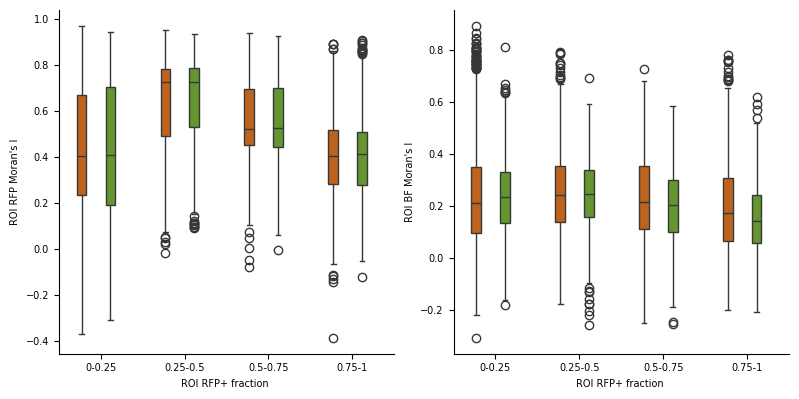

In [56]:


fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

# plot a boxplot of ROI RFP+ fraction of pixels (roi_rfp_pos_frac_quartile) by ROI RFP Moran's I (roi_rfp_morans_I)
sns.boxplot(data=df_polar, x='roi_rfp_pos_frac_quartile', y='roi_rfp_morans_I', hue='kmeans_7', palette='Dark2', ax=ax[0], legend=False)
ax[0].set_xlabel('ROI RFP+ fraction ')
ax[0].set_ylabel('ROI RFP Moran\'s I')
# rename x-tick labels based on quartile values
ax[0].set_xticklabels(['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1'])
sns.despine(ax=ax[0])

# plot the same boxplot as above but have the y-axis be roi_bf_morans_I instead of roi_rfp_morans_I
sns.boxplot(data=df_polar, x='roi_rfp_pos_frac_quartile', y='roi_bf_morans_I', hue='kmeans_7', palette='Dark2', ax=ax[1], legend=False)
ax[1].set_xlabel('ROI RFP+ fraction ')
ax[1].set_ylabel('ROI BF Moran\'s I')
# rename x-tick labels based on quartile values
ax[1].set_xticklabels(['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1'])
sns.despine(ax=ax[1])

plt.show()

/tmp/ipykernel_2033578/365605409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['kmeans_7'] = plot_data['kmeans_7'].astype('int')
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_num

ttest for  edges :  TtestResult(statistic=-4.034600728245674, pvalue=5.511945776262086e-05, df=9595.0)
ttest for  singlets :  TtestResult(statistic=22.053807964576894, pvalue=5.266532366347009e-106, df=14182.0)
ttest for  aggregates :  TtestResult(statistic=-17.699212835502845, pvalue=1.1737231974324148e-69, df=24108.0)


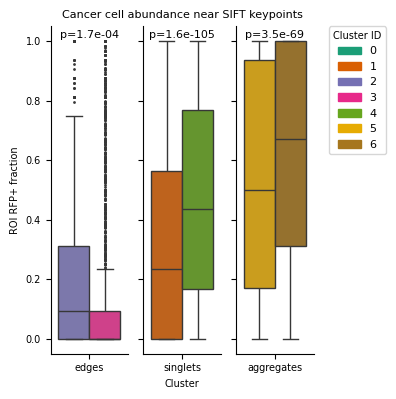

/tmp/ipykernel_2033578/365605409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['kmeans_7'] = plot_data['kmeans_7'].astype('int')
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_num

ttest for  edges :  TtestResult(statistic=-41.27504057462237, pvalue=0.0, df=9595.0)
ttest for  singlets :  TtestResult(statistic=4.386977182748849, pvalue=1.1576610737841396e-05, df=14182.0)
ttest for  aggregates :  TtestResult(statistic=-21.92930062492966, pvalue=1.4699676601476082e-105, df=24108.0)


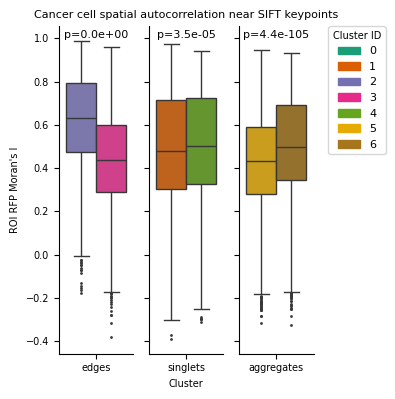

/tmp/ipykernel_2033578/365605409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['kmeans_7'] = plot_data['kmeans_7'].astype('int')
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_num

ttest for  edges :  TtestResult(statistic=18.58674880073659, pvalue=8.726339172924544e-76, df=9595.0)
ttest for  singlets :  TtestResult(statistic=-9.610680991404077, pvalue=8.398329898532777e-22, df=14182.0)
ttest for  aggregates :  TtestResult(statistic=-8.461444274003764, pvalue=2.788853293343629e-17, df=24108.0)


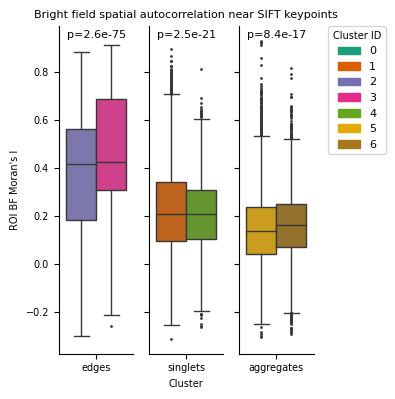

In [65]:

def boxplots_by_cluster_group(adata, cluster_color_dict=cluster_color_dict, ycol='roi_rfp_pos_frac', huecol='kmeans_7', ylabel='ROI RFP+ fraction', title=None, legend=True):
    fig, ax = plt.subplots(1, 3, figsize=(4, 4), tight_layout=True, sharey=True)

    cluster_groups = ['edges', 'singlets', 'aggregates']

    for i, group in enumerate(cluster_groups):
        plot_data = adata.obs[adata.obs['cluster_group'] == group]
        plot_data['kmeans_7'] = plot_data['kmeans_7'].astype('int')

        # compute a t-test between the two kmeans_7 clusters present in this cluster group
        cluster_ids = plot_data[huecol].unique()
        ttest = stats.ttest_ind(plot_data.loc[plot_data[huecol] == cluster_ids[0],ycol], plot_data.loc[plot_data[huecol] == cluster_ids[1],ycol])

        sns.boxplot(data=plot_data, x='cluster_group', y=ycol, hue=huecol, palette=cluster_color_dict, legend=False, ax=ax[i], fliersize=1)

        # add the p-value to the plot
        p_adj = ttest.pvalue * len(cluster_groups)
        ax[i].text(0.5, 0.99, f'p={p_adj:.1e}', transform=ax[i].transAxes, ha='center', va='top', fontsize=8)
        print('ttest for ', group, ': ', ttest)

        ax[i].set_xlabel('')
        ax[i].set_ylabel(ylabel)
        sns.despine(ax=ax[i])

    ax[1].set_title(title)
    ax[1].set_xlabel('Cluster')
    if legend:
        # create legend for ax[2] that shows the color corresponding to each kmeans_7 value
        handles = []
        for i in range(7):
            handles.append(patches.Patch(color=cluster_color_dict[i], label=str(i)))
        ax[2].legend(handles=handles, bbox_to_anchor=(1.2, 1), borderaxespad=0, title='Cluster ID', labels=range(7), fontsize=8)

    return fig, ax

fig, ax = boxplots_by_cluster_group(adata, ycol='roi_rfp_pos_frac', huecol='kmeans_7', ylabel='ROI RFP+ fraction', title='Cancer cell abundance near SIFT keypoints')
plt.show()
fig, ax = boxplots_by_cluster_group(adata, ycol='roi_rfp_morans_I', huecol='kmeans_7', ylabel='ROI RFP Moran\'s I', title='Cancer cell spatial autocorrelation near SIFT keypoints')
plt.show()
fig, ax = boxplots_by_cluster_group(adata, ycol='roi_bf_morans_I', huecol='kmeans_7', ylabel='ROI BF Moran\'s I', title='Bright field spatial autocorrelation near SIFT keypoints')
plt.show()

TtestResult(statistic=-63.953019448410295, pvalue=0.0, df=23779.0)
TtestResult(statistic=-38.49833706708582, pvalue=0.0, df=38292.0)


/tmp/ipykernel_2033578/2692560437.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['cluster_group'] = pd.Categorical(plot_data['cluster_group'], categories=['edges', 'singlets', 'aggregates'], ordered=True)
/gladstone/engelhardt/home/adamw/miniforge3/envs/saft/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


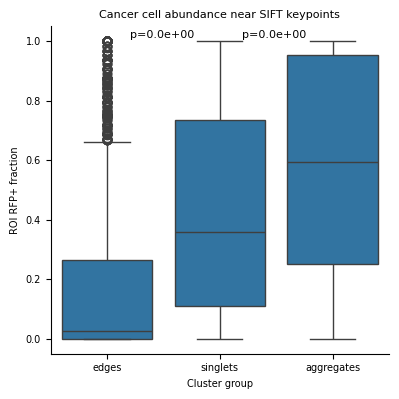

In [64]:
# create a boxplot of the ROI RFP+ fraction vs cluster group
fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)

# remove the mixed cluster group from this plot
plot_data = adata.obs[adata.obs['cluster_group'] != 'mixed']
# sort the plot data in the order of cluster_group such hat 'edges' are first, 'singlets' are second, and 'aggregates' are last
plot_data['cluster_group'] = pd.Categorical(plot_data['cluster_group'], categories=['edges', 'singlets', 'aggregates'], ordered=True)
plot_data = plot_data.sort_values('cluster_group')

sns.boxplot(data=plot_data, x='cluster_group', y='roi_rfp_pos_frac', legend=False)

# add the p-value to the plot
ttest = stats.ttest_ind(plot_data.loc[plot_data['cluster_group'] == 'edges','roi_rfp_pos_frac'], plot_data.loc[plot_data['cluster_group'] == 'singlets','roi_rfp_pos_frac'])
print(ttest)
p_adj = ttest.pvalue * 2
ax.text(0.33, 0.99, f'p={p_adj:.1e}', transform=ax.transAxes, ha='center', va='top', fontsize=8)

ttest = stats.ttest_ind(plot_data.loc[plot_data['cluster_group'] == 'singlets','roi_rfp_pos_frac'], plot_data.loc[plot_data['cluster_group'] == 'aggregates','roi_rfp_pos_frac'])
print(ttest)
p_adj = ttest.pvalue * 2
ax.text(0.66, 0.99, f'p={p_adj:.1e}', transform=ax.transAxes, ha='center', va='top', fontsize=8)

ax.set_xlabel('Cluster group')
ax.set_ylabel('ROI RFP+ fraction')
ax.set_title('Cancer cell abundance near SIFT keypoints')
sns.despine(ax=ax)
plt.show()

### Show the `k=7` clustering results alongside the other experimental covariates

This figure will accompany the statistical testing to show which clusters are enriched or depleted in certain experimental conditions. We expect there to be very minimal effect of donor and replicate (i.e. they are the negative controls) but there should be some effects over ratio, titration, and time.

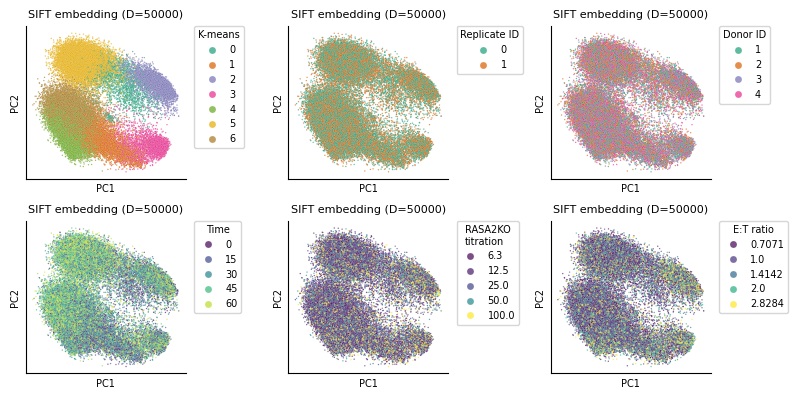

In [66]:
# create a matrix of SIFT PCA embeddings, annotating the points by donor_id, time, rasa2ko_titration, et_ratio
fig, ax = plt.subplots(2, 3, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

hue_cols = ['kmeans_7', 'replicate_id', 'donor_id', 'time', 'rasa2ko_titration', 'et_ratio']
hue_titles = ['K-means', 'Replicate ID', 'Donor ID', 'Time', 'RASA2KO\ntitration', 'E:T ratio']
cmaps = ['Dark2', 'Dark2', 'Dark2', 'viridis', 'viridis', 'viridis']
for i, hue in enumerate(hue_cols):
    # randomize the order of adata.obs so that one color isn't consistently plotted on top of another
    # plot_data = adata.obs.sample(frac=1)
    sns.scatterplot(data=adata.obs, x='PC1', y='PC2', hue=hue, palette=cmaps[i], ax=ax[i], legend=True, alpha=0.7, s=1)
    ax[i].set_title('SIFT embedding (D={})'.format(num_rows))
    ax[i].set_xlabel('PC1')
    ax[i].set_ylabel('PC2')
    sns.despine(ax=ax[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_titles[i], markerscale=5)


plt.show()

## Statistical testing

Perform a series of statistical tests to determine whether certatin clusters are enriched or depleted for their number of SIFT descriptors (i.e. rows in the dataframe) against a series of covariates `'donor_id', 'time', 'well_id', 'rasa2ko_titration', 'et_ratio'`.

A brief explanation is provided below each code block of statistical testing as the methods for generating the p-values and effect sizes vary between statistical test.

In [67]:


# Assume df is your dataframe
# Columns: ['et_ratio', 'rasa2ko_titration', 'time', 'donor_id', 'well_id', 'kmeans_7']
df = adata.obs

# # Option: Downsample your data to reduce overpowered tests
# subsample_size = 10000  # adjust as needed
# df = df.sample(n=subsample_size)

# Store p-values
p_values = {}

# 1. ANOVA for Continuous Variables (et_ratio, rasa2ko_titration, time)
continuous_vars = ['et_ratio', 'rasa2ko_titration', 'time']
for var in continuous_vars:
    model = ols(f"{var} ~ C(kmeans_7)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA
    p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value

# 2. Chi-square Test for Categorical Variables (donor_id, well_id)
categorical_vars = ['donor_id', 'replicate_id']
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df["kmeans_7"])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_values[var] = p

# 3. Multiple Testing Correction (FDR using Benjamini-Hochberg)
p_vals_corrected = multipletests(list(p_values.values()), method='fdr_bh')[1]

# Create a results DataFrame
results = pd.DataFrame({'var_name': p_values.keys(), 'p_val': p_values.values(), 'p_adj': p_vals_corrected})

# Sort results by adjusted p-value
results = results.sort_values(by='p_adj')

results

/tmp/ipykernel_2033578/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_2033578/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-value
/tmp/ipykernel_2033578/3945854203.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values[var] = anova_table["PR(>F)"][0]  # Extract p-v

var_name          p_val          p_adj
0           et_ratio   0.000000e+00   0.000000e+00
2               time   0.000000e+00   0.000000e+00
1  rasa2ko_titration  6.062777e-154  1.010463e-153
3           donor_id   2.417010e-98   3.021263e-98
4       replicate_id   1.701166e-06   1.701166e-06

#### Explanation:
1. ANOVA: Tests whether the mean of continuous variables (ratio, titration, time) significantly differs between clusters.
2. Chi-square Test: Checks if categorical variables (donor, well_id) are distributed differently across clusters.
3. FDR Correction: Uses the Benjamini-Hochberg method to control for false discovery rate (instead of Bonferroni, which is more conservative).

This will give you a table of p-values and adjusted p-values, helping you determine which covariates are significantly associated with cluster membership.

In [68]:
df = adata.obs

# # Option: Downsample your data to reduce overpowered tests
# df = df.sample(n=subsample_size)

# Assume df is your DataFrame with 'kmeans_7' and other variables
continuous_vars = ['time', 'et_ratio', 'rasa2ko_titration']
categorical_vars = ['donor_id', 'replicate_id']
results = []

### Function to compute Cohen's d (standardized effect size)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1) * std_x**2 + (ny - 1) * std_y**2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std if pooled_std > 0 else 0

# Iterate over each cluster
for cluster in df["kmeans_7"].unique():
    cluster_mask = df["kmeans_7"] == cluster

    # 1. Kruskal-Wallis Test for Continuous Variables
    for var in continuous_vars:
        cluster_values = df.loc[cluster_mask, var]
        other_values = df.loc[~cluster_mask, var]

        if len(cluster_values) > 1 and len(other_values) > 1:  # Ensure enough data points
            stat, p_val = stats.kruskal(cluster_values, other_values)
            effect_size = cohens_d(cluster_values, other_values)  # Cohen's d

            results.append([cluster, var, None, p_val, effect_size, 'kruskal', 'cohens_d'])  # 'var_value' is None

    # 2. Chi-square Test for Categorical Variables
    for var in categorical_vars:
        for val in df[var].unique():
            in_cluster = sum((df[var] == val) & cluster_mask)
            out_cluster = sum((df[var] == val) & ~cluster_mask)
            not_in_cluster = sum(cluster_mask) - in_cluster
            not_out_cluster = sum(~cluster_mask) - out_cluster
            contingency_table = np.array([[in_cluster, not_in_cluster],
                                          [out_cluster, not_out_cluster]])

            if contingency_table.min() < 5:
                test_name = 'fisher'
                oddsratio, p_val = stats.fisher_exact(contingency_table)
            else:
                test_name = 'chi2'
                chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
                oddsratio = (in_cluster * not_out_cluster) / max((out_cluster * not_in_cluster), 1)

            effect_size = np.log2(oddsratio) if oddsratio > 0 else 0  # Log2 odds ratio

            results.append([cluster, var, val, p_val, effect_size, test_name, 'log2_odds'])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['kmeans_7', 'var_name', 'var_value', 'p_val', 'effect_size', 'test_type', 'effect_type'])

# Apply Benjamini-Hochberg FDR correction
results_df['p_adj'] = multipletests(results_df['p_val'], method='fdr_bh')[1]

# compute absolute value of effect size
results_df['abs_effect_size'] = np.abs(results_df['effect_size'])

# compute -log10(p_adj)
results_df['-log10(p_adj)'] = -np.log10(results_df['p_adj'])

# Sort results by adjusted p-value for easier interpretation
results_df = results_df.sort_values(by=['-log10(p_adj)', 'abs_effect_size'], ascending=False)

results_df



kmeans_7           var_name  var_value          p_val  effect_size  \
45         1               time        NaN  9.630257e-232    -0.491847   
0          5               time        NaN  1.187947e-224     0.357280   
37         2           et_ratio        NaN  2.367297e-217     0.449455   
19         6           et_ratio        NaN  3.575792e-136    -0.252263   
38         2  rasa2ko_titration        NaN   5.452676e-82     0.282531   
..       ...                ...        ...            ...          ...   
5          5           donor_id        4.0   7.152423e-01     0.013012   
8          5       replicate_id        0.0   7.214999e-01    -0.011492   
7          5       replicate_id        1.0   7.214999e-01     0.011492   
62         0       replicate_id        0.0   8.462088e-01    -0.013899   
61         0       replicate_id        1.0   8.462088e-01     0.013899   

   test_type effect_type          p_adj  abs_effect_size  -log10(p_adj)  
45   kruskal    cohens_d  6.067062e-230         0.491847     229.217022  
0    kruskal    cohens_d  3.742033e-223         0.357280     222.426892  
37   kruskal    cohens_d  4.971323e-216         0.449455     215.303528  
19   kruskal    cohens_d  5.631872e-135         0.252263     134.249347  
38   kruskal    cohens_d   6.870372e-81         0.282531      80.163020  
..       ...         ...            ...              ...            ...  
5       chi2   log2_odds   7.451556e-01         0.013012       0.127753  
8       chi2   log2_odds   7.451556e-01         0.011492       0.127753  
7       chi2   log2_odds   7.451556e-01         0.011492       0.127753  
62      chi2   log2_odds   8.462088e-01         0.013899       0.072522  
61      chi2   log2_odds   8.462088e-01         0.013899       0.072522  

[63 rows x 10 columns]

#### Explanation of Code
1. Kruskal-Wallis test is used for continuous variables (`time`, `ratio`, `titration`).
    - Use Kruskal-Wallis (KW) test: Since time may not be normally distributed, KW is a non-parametric alternative to ANOVA that compares medians across clusters.
    - Effect size: Cohen’s d (standardized mean difference).
        - Measures how much the mean time value differs between the cluster and non-cluster points.
        - Positive d = cluster has later times, negative d = cluster has earlier times.
    - `var_value = None` because continuous variables don’t have discrete values like categorical ones.
2. Chi-square or Fisher’s exact test is used for categorical variables (`donor`, `replicate_id`).
    - Iterate through each cluster (kmeans_7) and each variable (ratio, titration, etc.).
    - For each unique value of the variable, create a 2×2 contingency table comparing its presence in the cluster vs. outside it.
    - Perform a statistical test:
        - Fisher’s exact test for small sample sizes (when any cell <5).
        - Chi-square test for larger samples.
    - Compute effect size:
        - Odds ratio measures enrichment/depletion.
        - Log2 transformation makes it more interpretable:
            - Positive = enriched in the cluster
            - Negative = depleted in the cluster
3. Benjamini-Hochberg (FDR) correction is applied to all p-values to control false discovery rate.

#### Interpretation
- Cluster 1 has significantly lower time values (p_adj = 0.005, Cohen’s d = -1.2).
- Cluster 1 is enriched for donor A1 (p_adj = 0.007, log2 odds ratio = 2.5).
- Cluster 2 has significantly higher titration values (p_adj = 0.02).
- Cluster 4 shows no significant association with replicate_id 0 (p_adj = 0.87).

In [69]:
results_df[results_df['p_adj'] < 0.05].var_name.value_counts()

var_name
donor_id             17
time                  7
et_ratio              6
rasa2ko_titration     6
replicate_id          6
Name: count, dtype: int64

In [70]:
results_df[(results_df['var_name'] == 'time')]

kmeans_7 var_name  var_value          p_val  effect_size test_type  \
45         1     time        NaN  9.630257e-232    -0.491847   kruskal   
0          5     time        NaN  1.187947e-224     0.357280   kruskal   
18         6     time        NaN   4.977026e-81     0.213732   kruskal   
54         0     time        NaN   1.590945e-68    -0.407789   kruskal   
9          4     time        NaN   7.403590e-58    -0.190492   kruskal   
27         3     time        NaN   3.047594e-05    -0.090697   kruskal   
36         2     time        NaN   6.349112e-03    -0.050233   kruskal   

   effect_type          p_adj  abs_effect_size  -log10(p_adj)  
45    cohens_d  6.067062e-230         0.491847     229.217022  
0     cohens_d  3.742033e-223         0.357280     222.426892  
18    cohens_d   5.225877e-80         0.213732      79.281841  
54    cohens_d   1.431851e-67         0.407789      66.844102  
9     cohens_d   5.830327e-57         0.190492      56.234307  
27    cohens_d   7.384554e-05         0.090697       4.131676  
36    cohens_d   1.142840e-02         0.050233       1.942014

In [71]:
results_df[(results_df['var_name'] == 'replicate_id')]

kmeans_7      var_name  var_value     p_val  effect_size test_type  \
26         6  replicate_id        0.0  0.000002     0.141211      chi2   
25         6  replicate_id        1.0  0.000002    -0.141211      chi2   
35         3  replicate_id        0.0  0.000646    -0.175648      chi2   
34         3  replicate_id        1.0  0.000646     0.175648      chi2   
43         2  replicate_id        1.0  0.002782     0.117698      chi2   
44         2  replicate_id        0.0  0.002782    -0.117698      chi2   
17         4  replicate_id        0.0  0.431798    -0.027004      chi2   
16         4  replicate_id        1.0  0.431798     0.027004      chi2   
52         1  replicate_id        1.0  0.459296    -0.031602      chi2   
53         1  replicate_id        0.0  0.459296     0.031602      chi2   
8          5  replicate_id        0.0  0.721500    -0.011492      chi2   
7          5  replicate_id        1.0  0.721500     0.011492      chi2   
62         0  replicate_id        0.0  0.846209    -0.013899      chi2   
61         0  replicate_id        1.0  0.846209     0.013899      chi2   

   effect_type     p_adj  abs_effect_size  -log10(p_adj)  
26   log2_odds  0.000004         0.141211       5.379460  
25   log2_odds  0.000004         0.141211       5.379460  
35   log2_odds  0.001312         0.175648       2.882080  
34   log2_odds  0.001312         0.175648       2.882080  
43   log2_odds  0.005155         0.117698       2.287741  
44   log2_odds  0.005155         0.117698       2.287741  
17   log2_odds  0.503764         0.027004       0.297773  
16   log2_odds  0.503764         0.027004       0.297773  
52   log2_odds  0.516708         0.031602       0.286754  
53   log2_odds  0.516708         0.031602       0.286754  
8    log2_odds  0.745156         0.011492       0.127753  
7    log2_odds  0.745156         0.011492       0.127753  
62   log2_odds  0.846209         0.013899       0.072522  
61   log2_odds  0.846209         0.013899       0.072522

In [72]:
results_df[(results_df['var_name'] == 'donor_id')]

kmeans_7  var_name  var_value         p_val  effect_size test_type  \
21         6  donor_id        3.0  7.962150e-39    -0.503107      chi2   
39         2  donor_id        3.0  1.759663e-32     0.537380      chi2   
41         2  donor_id        4.0  4.870678e-28    -0.506994      chi2   
23         6  donor_id        4.0  4.762836e-21     0.299416      chi2   
30         3  donor_id        3.0  3.618137e-16     0.481692      chi2   
4          5  donor_id        2.0  4.553004e-15     0.275328      chi2   
3          5  donor_id        3.0  7.809910e-10    -0.247639      chi2   
32         3  donor_id        4.0  2.950787e-09    -0.354270      chi2   
31         3  donor_id        2.0  2.438086e-04    -0.225178      chi2   
48         1  donor_id        3.0  5.035364e-04     0.177339      chi2   
24         6  donor_id        1.0  5.940794e-04     0.113908      chi2   
13         4  donor_id        2.0  1.283913e-03    -0.127628      chi2   
14         4  donor_id        4.0  7.341707e-03     0.099824      chi2   
51         1  donor_id        1.0  1.007482e-02    -0.125403      chi2   
6          5  donor_id        1.0  1.168137e-02    -0.090977      chi2   
12         4  donor_id        3.0  1.854980e-02     0.098659      chi2   
33         3  donor_id        1.0  2.137916e-02     0.132990      chi2   
59         0  donor_id        4.0  4.434805e-02    -0.147580      chi2   
15         4  donor_id        1.0  8.492065e-02    -0.067353      chi2   
57         0  donor_id        3.0  9.745693e-02     0.131712      chi2   
42         2  donor_id        1.0  1.400271e-01     0.065993      chi2   
49         1  donor_id        2.0  2.162258e-01    -0.060799      chi2   
22         6  donor_id        2.0  2.136402e-01    -0.042436      chi2   
40         2  donor_id        2.0  3.100912e-01    -0.046744      chi2   
58         0  donor_id        2.0  3.310993e-01     0.072872      chi2   
50         1  donor_id        4.0  5.459599e-01     0.028573      chi2   
60         0  donor_id        1.0  6.858810e-01    -0.031583      chi2   
5          5  donor_id        4.0  7.152423e-01     0.013012      chi2   

   effect_type         p_adj  abs_effect_size  -log10(p_adj)  
21   log2_odds  4.560140e-38         0.503107      37.341022  
39   log2_odds  9.238233e-32         0.537380      31.034411  
41   log2_odds  2.360405e-27         0.506994      26.627013  
23   log2_odds  2.143276e-20         0.299416      19.668922  
30   log2_odds  1.340839e-15         0.481692      14.872623  
4    log2_odds  1.593551e-14         0.275328      13.797634  
3    log2_odds  2.460122e-09         0.247639       8.609043  
32   log2_odds  8.852360e-09         0.354270       8.052941  
31   log2_odds  5.688868e-04         0.225178       3.244974  
48   log2_odds  1.132957e-03         0.177339       2.945787  
24   log2_odds  1.290586e-03         0.113908       2.889213  
13   log2_odds  2.527703e-03         0.127628       2.597274  
14   log2_odds  1.284799e-02         0.099824       1.891165  
51   log2_odds  1.715442e-02         0.125403       1.765624  
6    log2_odds  1.936648e-02         0.090977       1.712949  
12   log2_odds  2.921594e-02         0.098659       1.534380  
33   log2_odds  3.285091e-02         0.132990       1.483453  
59   log2_odds  6.497504e-02         0.147580       1.187253  
15   log2_odds  1.215909e-01         0.067353       0.915099  
57   log2_odds  1.364397e-01         0.131712       0.865059  
42   log2_odds  1.917762e-01         0.065993       0.717205  
49   log2_odds  2.837964e-01         0.060799       0.546993  
22   log2_odds  2.837964e-01         0.042436       0.546993  
40   log2_odds  3.907149e-01         0.046744       0.408140  
58   log2_odds  4.090050e-01         0.072872       0.388271  
50   log2_odds  6.034293e-01         0.028573       0.219374  
60   log2_odds  7.450087e-01         0.031583       0.127839  
5    log2_odds  7.451556e-01         0.013012       0.127753

In [73]:
results_df[(results_df['var_name'] == 'rasa2ko_titration')]

kmeans_7           var_name  var_value         p_val  effect_size  \
38         2  rasa2ko_titration        NaN  5.452676e-82     0.282531   
20         6  rasa2ko_titration        NaN  9.004517e-46    -0.162747   
29         3  rasa2ko_titration        NaN  2.739605e-16     0.177400   
2          5  rasa2ko_titration        NaN  2.253932e-12    -0.088317   
47         1  rasa2ko_titration        NaN  1.394698e-02     0.046196   
56         0  rasa2ko_titration        NaN  2.310099e-02     0.042893   
11         4  rasa2ko_titration        NaN  2.523683e-01    -0.008981   

   test_type effect_type         p_adj  abs_effect_size  -log10(p_adj)  
38   kruskal    cohens_d  6.870372e-81         0.282531      80.163020  
20   kruskal    cohens_d  5.672846e-45         0.162747      44.246199  
29   kruskal    cohens_d  1.078720e-15         0.177400      14.967091  
2    kruskal    cohens_d  7.473564e-12         0.088317      11.126472  
47   kruskal    cohens_d  2.252973e-02         0.046196       1.647244  
56   kruskal    cohens_d  3.465148e-02         0.042893       1.460278  
11   kruskal    cohens_d  3.244736e-01         0.008981       0.488821

In [74]:
results_df[(results_df['var_name'] == 'et_ratio')]

kmeans_7  var_name  var_value          p_val  effect_size test_type  \
37         2  et_ratio        NaN  2.367297e-217     0.449455   kruskal   
19         6  et_ratio        NaN  3.575792e-136    -0.252263   kruskal   
28         3  et_ratio        NaN   2.217507e-57     0.291714   kruskal   
1          5  et_ratio        NaN   5.514335e-20    -0.091751   kruskal   
55         0  et_ratio        NaN   2.002370e-08    -0.120346   kruskal   
10         4  et_ratio        NaN   7.154770e-06     0.028450   kruskal   
46         1  et_ratio        NaN   4.287941e-01    -0.017127   kruskal   

   effect_type          p_adj  abs_effect_size  -log10(p_adj)  
37    cohens_d  4.971323e-216         0.449455     215.303528  
19    cohens_d  5.631872e-135         0.252263     134.249347  
28    cohens_d   1.552255e-56         0.291714      55.809037  
1     cohens_d   2.316020e-19         0.091751      18.635258  
55    cohens_d   5.734060e-08         0.120346       7.241538  
10    cohens_d   1.803002e-05         0.028450       4.744004  
46    cohens_d   5.037639e-01         0.017127       0.297773

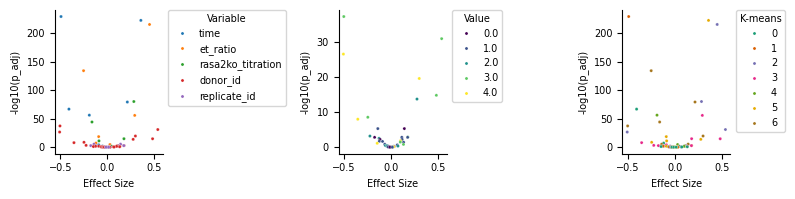

In [75]:
# make a volcano plot of results_df where we show -log10(p_adj) on the y axis
# and the effect_size on the x axis
fig, ax = plt.subplots(1, 3, figsize=(8, 2), tight_layout=True)
ax = ax.flatten()

hue_cols = ['var_name', 'var_value', 'kmeans_7']
hue_titles = ['Variable', 'Value', 'K-means']
cmaps = ['tab10', 'viridis', 'Dark2']
for i, hue_col in enumerate(hue_cols):
    sns.scatterplot(data=results_df, x='effect_size', y='-log10(p_adj)', hue=hue_col, ax=ax[i], s=5, palette=cmaps[i])
    hue_title = hue_titles[i]
    ax[i].set_xlabel('Effect Size')
    ax[i].set_ylabel('-log10(p_adj)')
    sns.despine(ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=hue_title)

plt.show()

In [76]:
results_df

kmeans_7           var_name  var_value          p_val  effect_size  \
45         1               time        NaN  9.630257e-232    -0.491847   
0          5               time        NaN  1.187947e-224     0.357280   
37         2           et_ratio        NaN  2.367297e-217     0.449455   
19         6           et_ratio        NaN  3.575792e-136    -0.252263   
38         2  rasa2ko_titration        NaN   5.452676e-82     0.282531   
..       ...                ...        ...            ...          ...   
5          5           donor_id        4.0   7.152423e-01     0.013012   
8          5       replicate_id        0.0   7.214999e-01    -0.011492   
7          5       replicate_id        1.0   7.214999e-01     0.011492   
62         0       replicate_id        0.0   8.462088e-01    -0.013899   
61         0       replicate_id        1.0   8.462088e-01     0.013899   

   test_type effect_type          p_adj  abs_effect_size  -log10(p_adj)  
45   kruskal    cohens_d  6.067062e-230         0.491847     229.217022  
0    kruskal    cohens_d  3.742033e-223         0.357280     222.426892  
37   kruskal    cohens_d  4.971323e-216         0.449455     215.303528  
19   kruskal    cohens_d  5.631872e-135         0.252263     134.249347  
38   kruskal    cohens_d   6.870372e-81         0.282531      80.163020  
..       ...         ...            ...              ...            ...  
5       chi2   log2_odds   7.451556e-01         0.013012       0.127753  
8       chi2   log2_odds   7.451556e-01         0.011492       0.127753  
7       chi2   log2_odds   7.451556e-01         0.011492       0.127753  
62      chi2   log2_odds   8.462088e-01         0.013899       0.072522  
61      chi2   log2_odds   8.462088e-01         0.013899       0.072522  

[63 rows x 10 columns]

/tmp/ipykernel_2033578/3735012695.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Dark2', len(covariates))


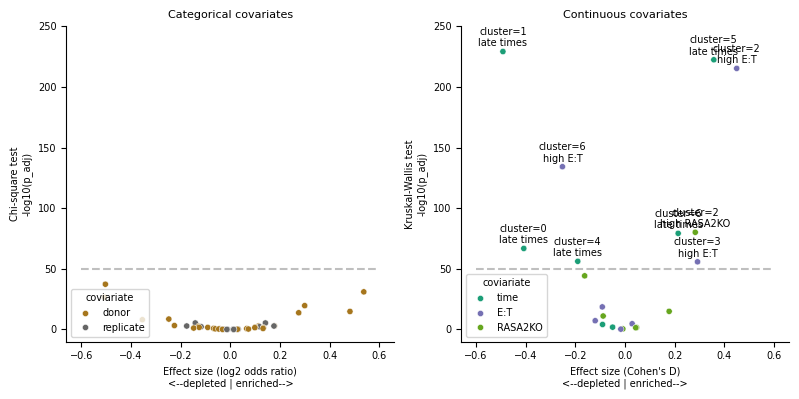

In [77]:
# an alternative volcano plot is one that colors all points with -log10(p_adj) <10 as grey and then
# labels all the other points with text showing the var_name, var_value, and kmeans_7 values
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax = ax.flatten()

color_threshold = 10
text_threshold = 50

var_name_dict = {'time': 'time', 'donor_id': 'donor', 'replicate_id': 'replicate',
                 'rasa2ko_titration': 'RASA2KO', 'et_ratio': 'E:T'}

results_df['covariate'] = results_df['var_name'].map(var_name_dict)

# create a unique colormap of all the unique covariates
covariates = results_df['covariate'].unique()
cmap = plt.cm.get_cmap('Dark2', len(covariates))
colors = cmap(np.arange(len(covariates)))

cmap = dict(zip(covariates, colors))

# subset results_df to only such that chi2 and kruskal tests are separate dataframes
plot1_df = results_df[results_df['test_type'] == 'chi2']
plot2_df = results_df[results_df['test_type'] == 'kruskal']

for i, plot_df in enumerate([plot1_df, plot2_df]):

    # # draw all the non-significant points in grey
    # sns.scatterplot(data=plot_df[plot_df['-log10(p_adj)'] < color_threshold], x='effect_size', y='-log10(p_adj)', ax=ax[i], color='grey', s=20)
    # # draw all the significant points, annotating each point with its kmeans_7, var_name, and var_value
    # sns.scatterplot(data=plot_df[plot_df['-log10(p_adj)'] >= color_threshold], x='effect_size', y='-log10(p_adj)', ax=ax[i], hue='covariate', palette=cmap, s=20)

    # draw all points with the color annotating the covariate
    sns.scatterplot(data=plot_df, x='effect_size', y='-log10(p_adj)', ax=ax[i], hue='covariate', palette=cmap, s=20)

    for _, row in plot_df[plot_df['-log10(p_adj)'] >= text_threshold].iterrows():
        if row['covariate'] == 'time':
            ax[i].annotate('cluster={}\nlate times'.format(row['kmeans_7']), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=SMALL_SIZE, color='black', xytext=(0, 10), textcoords='offset points')
        elif row['covariate'] == 'E:T':
            ax[i].annotate('cluster={}\nhigh E:T'.format(row['kmeans_7']), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=SMALL_SIZE, color='black', xytext=(0, 10), textcoords='offset points')
        elif row['covariate'] == 'RASA2KO':
            ax[i].annotate('cluster={}\nhigh RASA2KO'.format(row['kmeans_7']), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=SMALL_SIZE, color='black', xytext=(0, 10), textcoords='offset points')
        else:
            ax[i].annotate('cluster={}\n{}={}'.format(row['kmeans_7'], row['covariate'], round(row['var_value'], 2)), (row['effect_size'], row['-log10(p_adj)']),
                        ha='center', va='center', fontsize=SMALL_SIZE, color='black', xytext=(0, 10), textcoords='offset points')
    
    # draw a dashed horizontal line at y=50
    ax[i].hlines(y=50, xmin=-0.6, xmax=0.6, colors='grey', linestyles='dashed', alpha=0.5)

    sns.despine(ax=ax[i])
    ax[i].legend(title='coviariate', loc='lower left', markerscale=1)
    ax[i].set_ylim(-10, 250)


ax[0].set_xlabel('Effect size (log2 odds ratio)\n<--depleted | enriched-->')
ax[0].set_ylabel('Chi-square test\n-log10(p_adj)')
ax[0].set_title('Categorical covariates')

ax[1].set_xlabel("Effect size (Cohen's D)\n<--depleted | enriched-->")
ax[1].set_ylabel('Kruskal-Wallis test\n-log10(p_adj)')
ax[1].set_title('Continuous covariates')


plt.show()

In [ ]:
# save results_df to analysis file
# results_df.to_csv('analysis/sift_volcano_table.csv')